In [1]:
interval_width = 0.1
platflorm = 'k8s'
num_ues = 500
folder_path = f'data/{platflorm}/ue={num_ues}/record=5/procedures'
summary_results_path = f"data/{platflorm}/ue={num_ues}/record=5/registration_summary.csv"
summary_results_graph_path = f"data/{platflorm}/ue={num_ues}/record=5/"
procedures = ["5GMMRegistrationRequest", "5GMMAuthenticationRequest", "5GMMAuthenticationResponse", "5GMMSecurityModeCommand", "5GMMSecurityModeComplete", "5GMMRegistrationAccept", "5GMMRegistrationComplete", "5GMMMODeregistrationRequest", "5GMMMODeregistrationAccept", "5GMMANConnectionReleaseComplete"]

In [2]:
import pandas as pd
import glob

def read_csv_from_folder(folder_path):
  """
  This function reads all CSV files from a folder and combines them into a single pandas DataFrame.

  Args:
      folder_path (str): The path to the folder containing the CSV files.

  Returns:
      pandas.DataFrame: The combined DataFrame containing data from all CSV files.
  """
  # Construct the file path pattern using glob
  file_pattern = f"{folder_path}/*.csv"

  # Get all CSV file paths in the folder
  csv_files = glob.glob(file_pattern)

  # Check if any CSV files were found
  if not csv_files:
    print(f"No CSV files found in folder: {folder_path}")
    return None

  # Initialize an empty DataFrame to store the combined data
  df = pd.DataFrame()

  # Read each CSV file and append it to the DataFrame
  for file in csv_files:
    df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

  return df

def add_group_column_2(df, csv_file, group_width=0.1, headers=["5GMMRegistrationRequest", "5GMMRegistrationAccept"]):
  """
  This function reads a CSV file, adds new columns with group information for 
  specified columns in the DataFrame, and saves the modified data to a new CSV file.

  Args:
      df (pandas.DataFrame): The DataFrame to process.
      csv_file (str): The path to the CSV file.
      group_width (float, optional): The width of each group interval. Defaults to 0.1.
      base_suffix (str, optional): The suffix to append to the base column name. Defaults to "_001".
      target_suffix (str, optional): The suffix to append to the target column name. Defaults to "_01".

  Returns:
      pandas.DataFrame: The modified DataFrame.
  """

  df_cpy = df.copy()  # Avoid modifying original df
  df_grp = pd.DataFrame()
  min_value = df_cpy["5GMMRegistrationRequest"].min()

  print(df_cpy.head())
  df_grp['UE'] = df_cpy['UE']
  for col in df_cpy.filter(items=headers):
    df_grp[f"{col}_{group_width}"] = ((df_cpy[col] - min_value) // group_width) + 1

  # Create a new filename to avoid overwriting the original file
  new_filename = f"{csv_file[:-4]}_modified.csv"  # Remove '.csv' and add '_modified'

  # Save the modified DataFrame to a new CSV file
  df_grp.to_csv(new_filename, index=False)

  print(f"CSV file modified and saved as: {new_filename}")

  return df_grp

# Read data
combined_df = read_csv_from_folder(folder_path)

# Replace 'your_csv_file.csv' with the actual path to your CSV file
df_int = add_group_column_2(combined_df, 'data/proc_4.csv', interval_width, procedures)


   UE  5GMMRegistrationRequest  5GMMRegistrationAccept  \
0   4             1.719751e+09            1.719751e+09   
1   7             1.719751e+09            1.719751e+09   
2  10             1.719751e+09            1.719751e+09   
3  13             1.719751e+09            1.719751e+09   
4  16             1.719751e+09            1.719751e+09   

   5GMMRegistrationComplete  5GMMRegistrationReject  \
0              1.719751e+09                     NaN   
1              1.719751e+09                     NaN   
2              1.719751e+09                     NaN   
3              1.719751e+09                     NaN   
4              1.719751e+09                     NaN   

   5GMMMODeregistrationRequest  5GMMMODeregistrationAccept  \
0                 1.719751e+09                1.719751e+09   
1                 1.719751e+09                1.719751e+09   
2                 1.719751e+09                1.719751e+09   
3                 1.719751e+09                1.719751e+09   
4         

In [3]:
import numpy as np

def group_and_calculate(df, col):
  grouped = df.groupby(col).size().to_frame(name=col + 's')

  grouped = grouped.fillna(0)

  return grouped

def group_cummulative(df, col): 
  df['Cumulative_' + col] = df[col].transform('cumsum')
  return df

# Group and calculate for each column with generic column name
all_grouped_count = {}
for col in df_int.filter(like=f'_{interval_width}'):
  all_grouped_count[col] = group_and_calculate(df_int.copy(), col)  # Avoid modifying original df

# Combine the DataFrames
count_combined_df = pd.concat(all_grouped_count.values(), axis=1)
count_combined_df = count_combined_df.fillna(0)

print(count_combined_df.head(20))

# Create df for cummulative after merging the different times
all_grouped_cumm = {}
cumm_combined_df = count_combined_df.copy()
for col in count_combined_df.filter(like=f'_{interval_width}'):
  cumm_combined_df['Cumulative_' + col] = cumm_combined_df[col].transform('cumsum')
  # all_grouped_cumm[col] = group_cummulative(count_combined_df.copy(), col)  # Avoid modifying original df

# Create a row with NaN values for all columns
first_row = pd.DataFrame([[0] * len(cumm_combined_df.columns)], columns=cumm_combined_df.columns, index=[0])

# Insert the row at the beginning of combined_df
cumm_combined_df = pd.concat([first_row, cumm_combined_df], ignore_index=True)

# Add the sum of the active requests at a given time
cumm_combined_df[f'Total_ActiveRequets_{interval_width}s'] = cumm_combined_df[[f'{col}s' for col in df_int.filter(like=f'_{interval_width}')]].sum(axis=1)

cumm_combined_df['Time (seconds)'] = cumm_combined_df.index * interval_width

# Print results (optional)
print(cumm_combined_df.head())

# For cummulative stats NaN before the first request is initiated should be zero, and after the UEs complete should be equal to the total UEs
# cols = combined_df.filter(like='Cumulative_').columns
# combined_df[cols] = combined_df[cols].fillna(method='ffill')
# combined_df[cols] = combined_df[cols].fillna(0)


# Save to CSV file (optional)
cumm_combined_df.to_csv(summary_results_path, index=True)

      5GMMRegistrationRequest_0.1s  5GMMAuthenticationRequest_0.1s  \
1.0                           15.0                             0.0   
2.0                           17.0                             0.0   
3.0                           18.0                             0.0   
4.0                           19.0                             0.0   
5.0                           15.0                             0.0   
6.0                           18.0                             0.0   
7.0                           17.0                             0.0   
8.0                           18.0                             0.0   
9.0                           19.0                             0.0   
10.0                          19.0                             0.0   
11.0                          17.0                             0.0   
12.0                          19.0                             0.0   
13.0                          15.0                             0.0   
14.0                

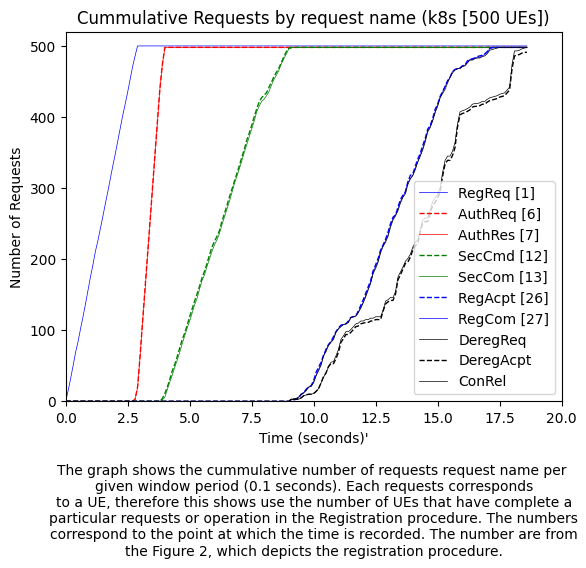

In [4]:
# Draw a line graphs for the start and end procedures
import matplotlib.pyplot as plt

# print(round(cumm_combined_df['Cumulative_5GMMRegistrationRequest_0.1s'].diff().mean(), 3))

fig, ax = plt.subplots()
ax.set_xlim([0, 20])
ax.set_ylim([0, 520])

ax.title.set_text(f'Cummulative Requests by request name ({platflorm} [{num_ues} UEs])')

ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMRegistrationRequest_{interval_width}s', c='blue', label='RegReq [1]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'Cumulative_5GMMAuthenticationRequest_{interval_width}s', c='red', label='AuthReq [6]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMAuthenticationResponse_{interval_width}s', c='red', label='AuthRes [7]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'Cumulative_5GMMSecurityModeCommand_{interval_width}s', c='green', label='SecCmd [12]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMSecurityModeComplete_{interval_width}s', c='green', label='SecCom [13]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'Cumulative_5GMMRegistrationAccept_{interval_width}s', c='blue', label='RegAcpt [26]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMRegistrationComplete_{interval_width}s', c='blue', label='RegCom [27]')

ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMMODeregistrationRequest_{interval_width}s', c='black', label='DeregReq')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'Cumulative_5GMMMODeregistrationAccept_{interval_width}s', c='black', label='DeregAcpt')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'Cumulative_5GMMANConnectionReleaseComplete_{interval_width}s', c='black', label='ConRel')

plt.ylabel('Number of Requests')
plt.xlabel(f'''Time (seconds)'

The graph shows the cummulative number of requests request name per 
given window period ({interval_width} seconds). Each requests corresponds
to a UE, therefore this shows use the number of UEs that have complete a
particular requests or operation in the Registration procedure. The numbers
correspond to the point at which the time is recorded. The number are from
the Figure 2, which depicts the registration procedure.''')

plt.legend(loc='best')
plt.show()
fig.savefig(summary_results_graph_path + "cummulative_registration_summary.png")
plt.close(fig)

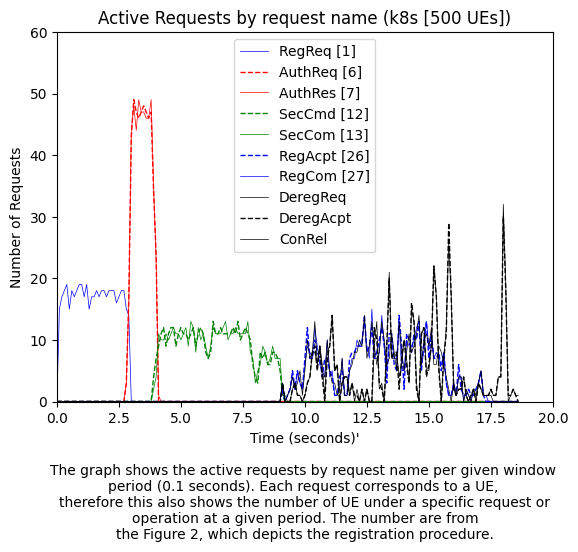

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim([0, 20])
ax.set_ylim([0, 60])

ax.title.set_text(f'Active Requests by request name ({platflorm} [{num_ues} UEs])')

ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMRegistrationRequest_{interval_width}s', c='blue', label='RegReq [1]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'5GMMAuthenticationRequest_{interval_width}s', c='red', label='AuthReq [6]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMAuthenticationResponse_{interval_width}s', c='red', label='AuthRes [7]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'5GMMSecurityModeCommand_{interval_width}s', c='green', label='SecCmd [12]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMSecurityModeComplete_{interval_width}s', c='green', label='SecCom [13]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'5GMMRegistrationAccept_{interval_width}s', c='blue', label='RegAcpt [26]')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMRegistrationComplete_{interval_width}s', c='blue', label='RegCom [27]')

ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMMODeregistrationRequest_{interval_width}s', c='black', label='DeregReq')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, linestyle='dashed', x='Time (seconds)', y=f'5GMMMODeregistrationAccept_{interval_width}s', c='black', label='DeregAcpt')
ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=0.5, x='Time (seconds)', y=f'5GMMANConnectionReleaseComplete_{interval_width}s', c='black', label='ConRel')

plt.ylabel('Number of Requests')
plt.xlabel(f'''Time (seconds)'

The graph shows the active requests by request name per given window 
period ({interval_width} seconds). Each request corresponds to a UE, 
therefore this also shows the number of UE under a specific request or
operation at a given period. The number are from
the Figure 2, which depicts the registration procedure.''')

plt.legend(loc='best')
plt.show()
fig.savefig(summary_results_graph_path + "active_registration_summary.png")
plt.close(fig)

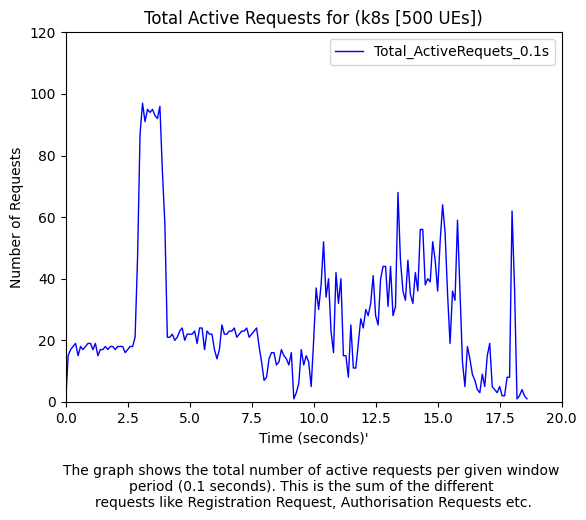

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim([0, 20])
ax.set_ylim([0, 120])

ax.title.set_text(f'Total Active Requests for ({platflorm} [{num_ues} UEs])')

ax = cumm_combined_df.plot(ax=ax, kind='line', linewidth=1, x='Time (seconds)', y=f'Total_ActiveRequets_{interval_width}s', c='blue')

plt.ylabel('Number of Requests')
plt.xlabel(f'''Time (seconds)'

The graph shows the total number of active requests per given window 
period ({interval_width} seconds). This is the sum of the different 
requests like Registration Request, Authorisation Requests etc.''')
plt.legend(loc='best')
plt.show()
fig.savefig(summary_results_graph_path + "total_active_registration_summary.png")
plt.close(fig)

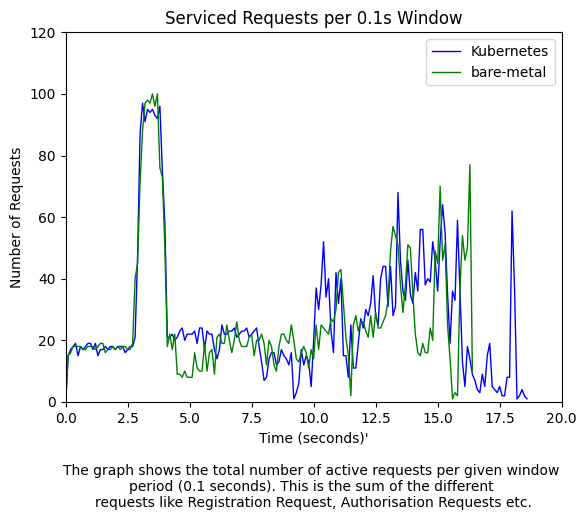

Unnamed: 0                                         186.0
5GMMRegistrationRequest_0.1s                        19.0
5GMMAuthenticationRequest_0.1s                      49.0
5GMMAuthenticationResponse_0.1s                     49.0
5GMMSecurityModeCommand_0.1s                        13.0
5GMMSecurityModeComplete_0.1s                       13.0
5GMMRegistrationAccept_0.1s                         14.0
5GMMRegistrationComplete_0.1s                       15.0
5GMMMODeregistrationRequest_0.1s                    14.0
5GMMMODeregistrationAccept_0.1s                     30.0
5GMMANConnectionReleaseComplete_0.1s                32.0
Cumulative_5GMMRegistrationRequest_0.1s            500.0
Cumulative_5GMMAuthenticationRequest_0.1s          498.0
Cumulative_5GMMAuthenticationResponse_0.1s         498.0
Cumulative_5GMMSecurityModeCommand_0.1s            498.0
Cumulative_5GMMSecurityModeComplete_0.1s           498.0
Cumulative_5GMMRegistrationAccept_0.1s             498.0
Cumulative_5GMMRegistrationComp

In [7]:
# Put the results on the same graph
df_k8s = pd.read_csv('data/k8s/ue=500/record=5/registration_summary.csv')
df_bm = pd.read_csv('data/baremetal/ue=500/record=1/registration_summary.csv')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim([0, 20])
ax.set_ylim([0, 120])

ax.title.set_text(f'Serviced Requests per 0.1s Window')

ax = df_k8s.plot(ax=ax, kind='line', linewidth=1, x='Time (seconds)', y=f'Total_ActiveRequets_{interval_width}s', c='blue', label='Kubernetes')
ax = df_bm.plot(ax=ax, kind='line', linewidth=1, x='Time (seconds)', y=f'Total_ActiveRequets_{interval_width}s', c='green', label='bare-metal')

plt.ylabel('Number of Requests')
plt.xlabel(f'''Time (seconds)'

The graph shows the total number of active requests per given window 
period ({interval_width} seconds). This is the sum of the different 
requests like Registration Request, Authorisation Requests etc.''')
plt.legend(loc='best')
plt.show()
fig.savefig("k8s_vs_baremetal_request_throughput.png")
plt.close(fig)

print(df_k8s.max())
print(df_bm.max())
